In [3]:
import time
import os
import uiautomator2 as u2
import easyocr
import multiprocessing
from PIL import Image


PAGE_INDICATOR = {
    "模拟炒股": "com.hexin.plat.android:id/tab_mn",
    "返回": "com.hexin.plat.android:id/title_bar_img",
    "股票多选": "com.hexin.plat.android:id/stockname_tv",
    "关闭按钮1": "com.hexin.plat.android:id/close_btn",
    "确定按钮": "com.hexin.plat.android:id/ok_btn",
}

MAX_COUNT = 1000   # 最大可显示持仓数目，调试用

class THSTrader:
    def __init__(self, serial="emulator-5554") -> None:
        
        self.d =  u2.connect_usb(serial)
        self.reader = easyocr.Reader(['ch_sim','en'])
        self.__back_to_moni_page()

    
    def get_balance(self):
        """ 获取资产 

        例如：

        {
            '总资产': 199987.96,
            '可用余额': 170632.4,
            '股票市值': 10146.0
        }
        
        """
        self.__back_to_moni_page()
        self.d(resourceId=f"com.hexin.plat.android:id/menu_holdings_image").click()
        time.sleep(1)
        self.d.swipe(340, 600, 340, 1000)
        time.sleep(1)
        return {
            "总资产": float(self.d(resourceId="com.hexin.plat.android:id/totalasset_value").get_text().replace(",", "")),
            "可用余额": float(self.d(resourceId="com.hexin.plat.android:id/canuse_value").get_text().replace(",", "")),
            "股票市值": float(self.d(resourceId="com.hexin.plat.android:id/totalworth_value").get_text().replace(",", "")),
        }
    
    def get_position(self):
        """ 获取当前持有股票 

        例如：
        
            [{
                '股票名称': '美的集团',
                '股票余额': 100,
                '可用余额': 0
            }, {
                '股票名称': '平安银行',
                '股票余额': 200,
                '可用余额': 200
            }, {
                '股票名称': '浦发银行',
                '股票余额': 100,
                '可用余额': 100
            }, {
                '股票名称': '工商银行',
                '股票余额': 100,
                '可用余额': 100
            }, {
                '股票名称': '中国银行',
                '股票余额': 100,
                '可用余额': 100
            }]
        
            因为A股是T+1，可用余额为当前可以卖出下单的
        """
        self.__back_to_moni_page()
        self.d(resourceId=f"com.hexin.plat.android:id/menu_holdings_image").click()
        time.sleep(1)
        i = 0
        first = True
        while True:
#             print(i)
            if i > MAX_COUNT:
                break
            try:
                self.d.xpath(f'//*[@resource-id="com.hexin.plat.android:id/recyclerview_id"]/android.widget.RelativeLayout[{i+1}]').screenshot().save(f"tmp{i}.png")
                i += 1
                self.d.swipe(340, 1000, 340, 890)
            except:
                if first:
                    self.d.swipe(340, 1000, 340, 600)  # 滑动后还是找不到才退出
                    first = False
                else:
                    break
        
        count = i
        holdings = []
        for i in range(count):
            holdings.append(self.__ocr_parse_holding(f"tmp{i}.png"))
        
        return holdings
    
    
   
    
    def get_avail_withdrawals(self):
        """ 获取可以撤单的列表 """
        self.__back_to_moni_page()
        self.d(resourceId=f"com.hexin.plat.android:id/menu_withdrawal_image").click()
        time.sleep(1)
        
        i = 0
        first=True
        while True:
#             print(i)
            if i > MAX_COUNT:
                break
            try:
                self.d.xpath(f'//*[@resource-id="com.hexin.plat.android:id/chedan_recycler_view"]/android.widget.LinearLayout[{i+1}]').screenshot().save(f"tmp{i}.png")
                i += 1
                self.d.swipe(340, 1000, 340, 890)
            except:
                if first:
                    self.d.swipe(340, 1000, 340, 600)  # 滑动后还是找不到才退出
                    first = False
                else:
                    break
        count = i
        withdrawals = []
        for i in range(count):
            withdrawals.append(self.__ocr_parse_withdrawal(f"tmp{i}.png"))
        
        return withdrawals
    
    
    def withdraw(self, stock_name, t, amount, price):
        """ 撤单 """
        self.__back_to_moni_page()
        self.d(resourceId=f"com.hexin.plat.android:id/menu_withdrawal_image").click()
        time.sleep(1)
        success = False
        i = 0
        first = True
        while True:
#             print(i)
            if i > MAX_COUNT:
                break
            try:
                self.d.xpath(f'//*[@resource-id="com.hexin.plat.android:id/chedan_recycler_view"]/android.widget.LinearLayout[{i+1}]').screenshot().save(f"tmp{i}.png")
                info = self.__ocr_parse_withdrawal(f"tmp{i}.png")
                if (stock_name == info["股票名称"]) and int(amount) == int(info["委托数量"]) \
                        and (abs(float(price) -  float(info["委托价格"])) < 0.01) and (t == info["委托类型"]):
                            self.d.xpath(f'//*[@resource-id="com.hexin.plat.android:id/chedan_recycler_view"]/android.widget.LinearLayout[{i+1}]').click()
                            time.sleep(1)
                            self.d(resourceId="com.hexin.plat.android:id/option_chedan").click()
                            time.sleep(1)
                            success = True
                            break
                
                i += 1
                self.d.swipe(340, 1000, 340, 890)
            except:
                if first:
                    self.d.swipe(340, 1000, 340, 600)  # 滑动后还是找不到才退出
                    first = False
                else:
                    break
        return {
            "success": success
        }

    def buy(self, stock_no, amount, price):
        return self.__imeaction(stock_no, amount, price, "menu_buy_image")
        
    def sell(self, stock_no, amount, price):
        return self.__imeaction(stock_no, amount, price, "menu_sale_image")

    def __imeaction(self, stock_no, amount, price, open_tag):
        """ 买入或者卖出通用 """
        stock_no = str(stock_no)
        amount = str(amount)
        price = str(price)
        success = False
        msg = ""
        stock_name = ""
        while True:
            self.__back_to_moni_page()
            self.d(resourceId=f"com.hexin.plat.android:id/{open_tag}").click()
            self.__input_stock_no(stock_no)
            self.__input_stock_price(price)
            self.__input_stock_buy_count(amount)
            self.d.xpath('//*[@resource-id="com.hexin.plat.android:id/transaction_layout"]/android.widget.LinearLayout[1]').click()
            time.sleep(1)
            if self.__entrust_doubel_check(stock_no, amount, price):
                try:
                    stock_name = self.d(resourceId="com.hexin.plat.android:id/stock_name_value").get_text()
                    self.d(resourceId="com.hexin.plat.android:id/ok_btn").click()
                    time.sleep(1)
                    self.d(resourceId="com.hexin.plat.android:id/content_scroll").screenshot().save(f"tmp.png")
                    msg = self.__ocr_get_full_text()
                    self.d(resourceId="com.hexin.plat.android:id/ok_btn").click()
                    success = True
                    break
                except: 
                    raise
            else:
                self.d(resourceId="com.hexin.plat.android:id/cancel_btn").click()
                time.sleep(2)
                
        if open_tag == "menu_buy_image":
            t = "买入"
        else:
            t = "卖出"
        return {
            "success": success,
            "msg": msg,
            "stock_name": stock_name.replace(" ", ""),
            "amount": amount,
            "price": price,
            "type": t
        }

    def __entrust_doubel_check(self, stock_no, amount, price):
        time.sleep(1)
        if self.d(resourceId="com.hexin.plat.android:id/stock_code_value").get_text().replace(" ", "") != stock_no:
            return False
        
        if self.d(resourceId="com.hexin.plat.android:id/number_value").get_text().replace(" ", "").replace(",", "") != amount:
            return False
        
        price = float(price)
        pnow = float(self.d(resourceId="com.hexin.plat.android:id/price_value").get_text())
        if abs(price - pnow) > 0.01:
            return False
        
        return True

    def __back_to_moni_page(self):
        self.__util_close_other()
        self.d.app_start("com.hexin.plat.android")
        self.d.xpath('//*[@content-desc="交易"]/android.widget.ImageView[1]').click()
        if self.__util_check_app_page(PAGE_INDICATOR["返回"]):
            try:
                self.d(resourceId="com.hexin.plat.android:id/title_bar_img").click()
            except: pass 

        self.d(resourceId="com.hexin.plat.android:id/tab_mn").click()

           
    
    def __input_stock_no(self, stock_no):
        """ 输入股票ID """
        self.__util_close_other()
        self.d(resourceId="com.hexin.plat.android:id/content_stock").click()
        time.sleep(2)
        self.__util_input_text(stock_no)
        time.sleep(2)
        if self.__util_check_app_page(PAGE_INDICATOR["股票多选"]):
            try:
                self.d.xpath('//*[@resource-id="com.hexin.plat.android:id/recyclerView"]/android.widget.RelativeLayout[1]').click()
            except: pass

    def __input_stock_price(self, price):
        """ 输入股票价格 """
        self.__util_close_other()
        self.d(resourceId="com.hexin.plat.android:id/stockprice").click()
        time.sleep(2)
        self.__util_input_text(price)

    def __input_stock_buy_count(self, buy_count):
        """ 输入股票购买量 """
        self.__util_close_other()
        self.d(resourceId="com.hexin.plat.android:id/stockvolume").click()
        time.sleep(2)
        self.__util_input_text(buy_count)

    def __util_close_other(self):
        time.sleep(1)
        if self.__util_check_app_page(PAGE_INDICATOR["关闭按钮1"]):
            try:
                self.d(resourceId=PAGE_INDICATOR["关闭按钮1"]).click()
            except: pass
        
        if self.__util_check_app_page(PAGE_INDICATOR["确定按钮"]):
            try:
                self.d(resourceId=PAGE_INDICATOR["确定按钮"]).click()
            except: pass

    def __util_input_text(self, text):
        """ 输入工具，uiautomator2的clear_text和send_keys速度好像有点儿慢，所以用了这种方法 """
        self.d.shell("input keyevent 123")
        for _ in range(20):
            self.d.shell("input keyevent 67")
        self.d.shell(f"input text {text}")

    def __util_check_app_page(self, indicator):
        """ 工具，检查页面是否包含某特征 """
        hierachy = self.d.dump_hierarchy()
        if indicator in hierachy:
            return True
        return False
    
    def __ocr_get_full_text(self):
        result = self.reader.readtext("tmp.png")
        text = ""
        for line in result:
            text += line[1]
        return text

    
    def __ocr_parse_holding(self, path):
        Image.open(path).crop((11, 11, 165, 55)).save("tmp.png")
        result = self.reader.readtext(f'tmp.png')
        stock_name = result[0][1]
        Image.open(path).crop((419, 11, 548, 55)).save("tmp.png")
        result = self.reader.readtext(f'tmp.png')
        stock_count = result[0][1]
        Image.open(path).crop((419, 60, 548, 102)).save("tmp.png")
        
        result = self.reader.readtext(f'tmp.png')
        try:
            stock_available = result[0][1]
        except:
            stock_available = "0"
        return {
            "股票名称": stock_name.replace(" ", ""),
            "股票余额": int(stock_count.replace(",", "")),
            "可用余额": int(stock_available.replace(",", ""))
        }
    
    def __ocr_parse_withdrawal(self, path):
        Image.open(path).crop((11, 11, 165, 55)).save("tmp.png")
        result = self.reader.readtext(f'tmp.png')
        stock_name = result[0][1]
        Image.open(path).crop((219, 11, 390, 55)).save("tmp.png")
        result = self.reader.readtext(f'tmp.png')
        stock_price = result[0][1]
        Image.open(path).crop((419, 11, 548, 55)).save("tmp.png")
        result = self.reader.readtext(f'tmp.png')
        stock_count = result[0][1]
        Image.open(path).crop((589, 11, 704, 55)).save("tmp.png")
        result = self.reader.readtext(f'tmp.png')
        t = result[0][1]
        return {
            "股票名称": stock_name.replace(" ", ""),
            "委托价格": float(stock_price.replace(",", "")),
            "委托数量": int(stock_count.replace(",", "")),
            "委托类型": t.replace(" ", "")
        }
    



In [2]:
trader = THSTrader(r"emulator-5554")


KeyboardInterrupt



In [61]:
trader.get_balance()

ValueError: could not convert string to float: '--'

In [62]:
trader.get_position()

[]

In [21]:
# trader.buy(stock_no="300467", amount=5000, price=18.12)

{'success': True,
 'msg': '柜台 :可用余额不够。还差:18648.99',
 'stock_name': '迅游科技',
 'amount': '5000',
 'price': '18.12',
 'type': '买入'}

In [58]:
#trader.sell(stock_no="300467", amount=100, price=4.00)

KeyboardInterrupt: 

In [7]:
# 获取当前可撤单列表
# trader.get_avail_withdrawals()

In [8]:
# 买卖撤单
# trader.withdraw(stock_name="中国银行", t="买入", amount=300, price=3.94)

In [1]:

import efinance as ef
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
# 股票代码
stock_code = '600519'
# 数据间隔时间为 1 分钟
freq = 1
status = {stock_code: 0}
# while 1:
#     # 获取最新一个交易日的分钟级别股票行情数据
#     df = ef.stock.get_quote_history(
#         stock_code, klt=freq)
#     # 现在的时间
#     now = str(datetime.today()).split('.')[0]
    
    # 将数据存储到 csv 文件中
#     df.to_csv(f'{stock_code}.csv', encoding='utf-8-sig', index=None)
#     print(f'已在 {now}, 将股票: {stock_code} 的行情数据存储到文件: {stock_code}.csv 中！')
#     if len(df) == status[stock_code]:
#         print(f'{stock_code} 已收盘')
#         break
#     status[stock_code] = len(df)
#     print('暂停 60 秒')
#     time.sleep(60)
#     print('-'*10)
 
# print('全部股票已收盘')

class Stock(object):
    def __init__(self, stock_code: int|str):
        self.stock_code = str(stock_code)
    
    def get_freq_data(self, freq: int, beg: int, end: int):
        ''' 
        返回股价数据dataFrame

        freq:
            1 : 1分钟，只有最近一天的数据
            5 : 5 分钟
            15 : 15 分钟
            30 : 30 分钟
            60 : 60 分钟
            101 : 日
            102 : 周
            103 : 月
        
        beg/end:
            例如 20240101表示2024年1月1日

            '''
        df_res= ef.stock.get_quote_history(
                self.stock_code,klt=freq,beg=str(beg), end=str(end)
                )
        return df_res

    def get_curr_data(self):
        '''获取实时1min数据'''
        df = ef.stock.get_quote_history(self.stock_code,klt=freq)
        latest_data = df.tail(1)
        return latest_data
    
    def show_price_mean_function(self, freq: int, beg: int, end: int):
        df = self.get_freq_data(freq=freq, beg= beg, end= end)
        ma5 = df['收盘'].rolling(window=5).mean()
        ma10 = df['收盘'].rolling(window=10).mean()
        ma20 = df['收盘'].rolling(window=20).mean()
        
        # 计算线性回归
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(ma10.dropna())), ma10.dropna())
        
        # 打印线性回归结果
        if p_value < 0.01 and slope > 0 and r_value**2 > 0.88:
            print(f"斜率: {slope}")
            print(f"截距: {intercept}")
            print(f"R²: {r_value**2}")
        else:
            print('非持续上升')
        
        
        
        regress_line = [slope * (x-9) + intercept for x in range(len(ma20))]
        # 绘制结果
        plt.scatter(range(len(df['收盘'])), df['收盘'], label='price_mean')
        # plt.plot(range(len(pma)), pma, label='pma')
        plt.plot(range(len(ma5)), ma5, label= 'ma5')
        plt.plot(range(len(ma10)), ma10, label= 'ma10')
        # plt.plot(range(len(ma20)), ma20, label= 'ma20')
        plt.plot(range(len(regress_line)), regress_line, label= 'reg_line')
        plt.legend()
        plt.title('price_mean_function')
        plt.show()

    def show_price_increament(self, freq: int, beg: int, end: int):
        df = self.get_freq_data(freq=freq, beg= beg, end= end)
        price_increament = df['涨跌额']
        plt.plot(range(len(price_increament)), price_increament)
        plt.title('price_increament')
        plt.show()

    def show_price_increament_rate(self, freq: int, beg: int, end: int):
        df = self.get_freq_data(freq=freq, beg= beg, end= end)
        price_increament = df['涨跌幅']
        plt.plot(range(len(price_increament)), price_increament)
        plt.title('price_increament_rate')
        plt.show()

    def show_VOL(self, freq: int, beg: int, end: int):
        df = self.get_freq_data(freq=freq, beg= beg, end= end)
        VOL = df['成交量']
        plt.plot(range(len(VOL)), VOL)
        plt.title('VOL')
        plt.show()

    def show_turnover(self, freq: int, beg: int, end: int):
        df = self.get_freq_data(freq=freq, beg= beg, end= end)
        turnover = df['成交额']
        plt.plot(range(len(turnover)), turnover)
        plt.title('turnover')
        plt.show()


c:\programs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


非持续上升


C:\Users\32356\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


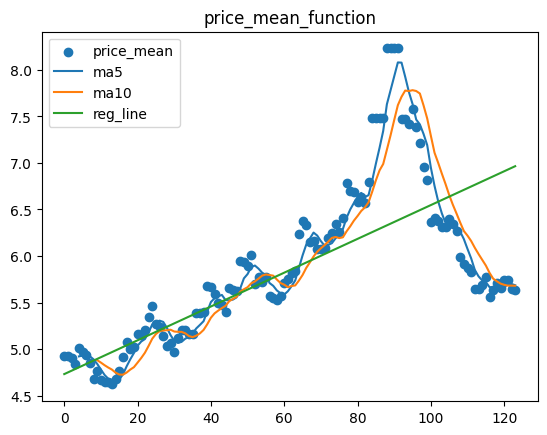

In [2]:
stock = Stock('600556')
stock.show_price_mean_function(freq=60, beg=20240801, end=20241226)

In [5]:
from datetime import datetime, timedelta
import ta  # 需要安装ta库: pip install ta
import numpy as np
def get_stock_data(stock_code: int|str, time_period: int):
    # 获取当天日期
    today = datetime.today().date()
    date_days_ago = today - timedelta(days=time_period)
    today = int(today.strftime("%Y%m%d"))
    date_days_ago = int(date_days_ago.strftime("%Y%m%d"))
    stock = Stock(stock_code=stock_code)
    stock.show_price_mean_function(freq= 101, beg= date_days_ago, end= today)
    stock.show_price_increament_rate(freq= 101, beg= date_days_ago, end= today)
    stock.show_price_increament(freq= 101, beg= date_days_ago, end= today)
    stock.show_VOL(freq= 101, beg= date_days_ago, end= today)
    print(stock.get_curr_data()) 
    df = stock.get_freq_data(freq= 101, beg= date_days_ago, end= today)
    # 计算RSI
    df['RSI'] = ta.momentum.RSIIndicator(df['收盘']).rsi()
    if df['RSI'].iloc[-1] > 50:
        print("RSI显示股价在上涨趋势中")

    # 计算MACD
    macd = ta.trend.MACD(df['收盘'])
    df['MACD'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    if df['MACD'].iloc[-1] > df['Signal_Line'].iloc[-1]:
        print("MACD显示股价在上涨趋势中")
    
    


斜率: 0.06913803475935829
截距: 4.3152156862745095
R²: 0.8937467780594625


C:\Users\32356\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


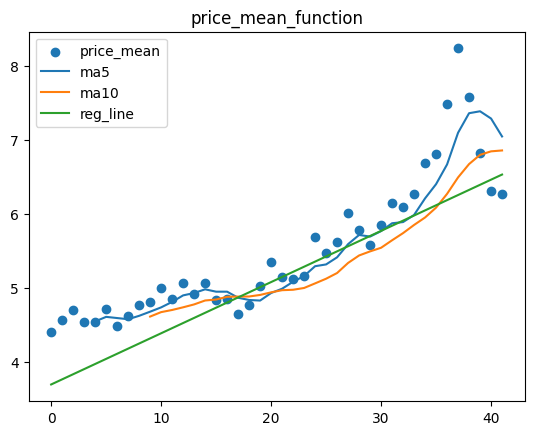

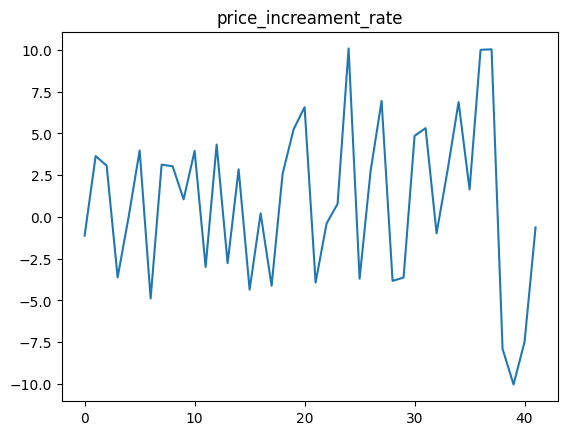

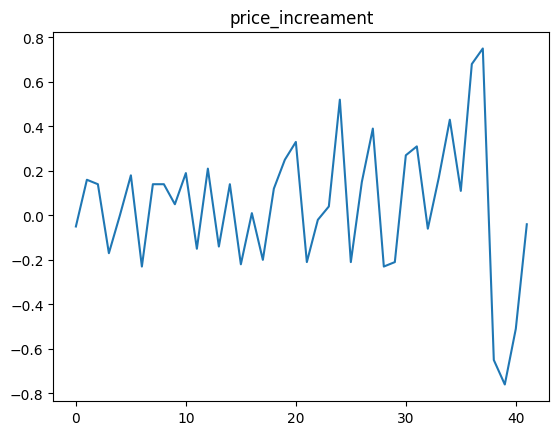

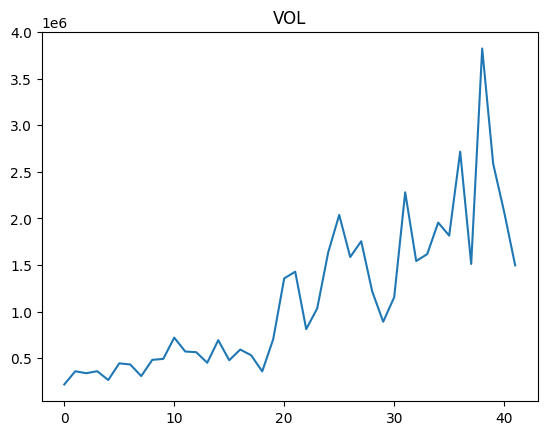

    股票名称    股票代码                日期    开盘    收盘    最高    最低    成交量         成交额  \
239  天下秀  600556  2024-12-20 15:00  6.27  6.27  6.27  6.27  21304  13357608.0   

      振幅  涨跌幅  涨跌额   换手率  
239  0.0  0.0  0.0  0.12  
RSI显示股价在上涨趋势中


In [6]:
get_stock_data(stock_code= '600556', time_period= 60)

In [6]:
from datetime import datetime
import requests
import json

class QuantTrader(object):
    def __init__(self):
        self.THS = THSTrader(r"emulator-5554")
    

    def update_account_info(self):
        self.my_balance = self.THS.get_balance()
        self.my_stocks = self.THS.get_position()

    def get_sector_data(self, sector: str) -> pd.DataFrame:
        '''
        获取东方财富板块涨跌榜上股票信息，返回一个df，目前有的列名：
            stockCode: 股票代码
        '''
        
        def get_response_str(sector) -> str:
            '''爬取东方财富板块涨跌榜上股票信息，返回response字符串'''
            cookies = {
                'qgqp_b_id': 'bbab04bb75eb4ff7d0ac80095f74c2ae',
                'emshistory': '%5B%22%E4%BB%BB%E5%A4%A9%E5%A0%82%22%2C%22%E6%B8%B8%E6%88%8F%22%5D',
                'websitepoptg_api_time': '1734286731603',
                'HAList': 'ty-1-600519-%u8D35%u5DDE%u8305%u53F0%2Cty-90-BK1046-%u6E38%u620F%2Cty-1-603986-%u5146%u6613%u521B%u65B0%2Cty-0-300795-%u7C73%u5965%u4F1A%u5C55%2Cty-90-BK0486-%u6587%u5316%u4F20%u5A92%2Cty-1-603258-%u7535%u9B42%u7F51%u7EDC%2Cty-0-300280-%u7D2B%u5929%u79D1%u6280%2Cty-1-600892-%u5927%u665F%u6587%u5316%2Cty-0-300113-%u987A%u7F51%u79D1%u6280%2Cty-1-600633-%u6D59%u6570%u6587%u5316',
                'st_si': '14539794737348',
                'st_pvi': '04649914865772',
                'st_sp': '2024-05-07%2000%3A19%3A07',
                'st_inirUrl': 'https%3A%2F%2Fwww.bing.com%2F',
                'st_sn': '1',
                'st_psi': '20241217012050763-113200301321-5175609964',
                'st_asi': 'delete',
            }
            headers = {
                'Accept': '*/*',
                'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
                'Connection': 'keep-alive',
                # Requests sorts cookies= alphabetically
                # 'Cookie': 'qgqp_b_id=bbab04bb75eb4ff7d0ac80095f74c2ae; emshistory=%5B%22%E4%BB%BB%E5%A4%A9%E5%A0%82%22%2C%22%E6%B8%B8%E6%88%8F%22%5D; websitepoptg_api_time=1734286731603; HAList=ty-1-600519-%u8D35%u5DDE%u8305%u53F0%2Cty-90-BK1046-%u6E38%u620F%2Cty-1-603986-%u5146%u6613%u521B%u65B0%2Cty-0-300795-%u7C73%u5965%u4F1A%u5C55%2Cty-90-BK0486-%u6587%u5316%u4F20%u5A92%2Cty-1-603258-%u7535%u9B42%u7F51%u7EDC%2Cty-0-300280-%u7D2B%u5929%u79D1%u6280%2Cty-1-600892-%u5927%u665F%u6587%u5316%2Cty-0-300113-%u987A%u7F51%u79D1%u6280%2Cty-1-600633-%u6D59%u6570%u6587%u5316; st_si=14539794737348; st_pvi=04649914865772; st_sp=2024-05-07%2000%3A19%3A07; st_inirUrl=https%3A%2F%2Fwww.bing.com%2F; st_sn=1; st_psi=20241217012050763-113200301321-5175609964; st_asi=delete',
                'Referer': 'https://quote.eastmoney.com/center/boardlist.html',
                'Sec-Fetch-Dest': 'script',
                'Sec-Fetch-Mode': 'no-cors',
                'Sec-Fetch-Site': 'same-site',
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
                'sec-ch-ua': '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
                'sec-ch-ua-mobile': '?0',
                'sec-ch-ua-platform': '"Windows"',
            }
            url = f'https://54.push2.eastmoney.com/api/qt/clist/get?cb=jQuery112403762781731857183_1734390159818&pn=1&pz=100&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&dect=1&wbp2u=|0|0|0|web&fid=f3&fs=b:{sector}+f:!50&fields=f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f16,f17,f18,f20,f21,f23,f24,f25,f22,f11,f62,f128,f136,f115,f152,f45&_=1734390159819'
            response = requests.get(url, cookies=cookies, headers=headers)
            if response.status_code == 200:
                response_str = response.text
                return response_str
            else:
                raise ValueError(f'Unexpected status code {response.status_code} is received')
            

        def extract_stock_info(response_str) -> pd.DataFrame:
            '''
            返回板块股票信息DataFrame
            '''
            # 将response字符串转为字典格式：
            start_index = response_str.find('(')
            end_index = response_str.rfind(')')
            if start_index != -1 and end_index != -1:
                json_str = response_str[start_index+1:end_index]
                data_dict = json.loads(json_str)
            else:
                raise LookupError(f'Fail to convert request response.text to dictionary, check the unexpected response.text as \n {response_str}')
            # 提取键名构建DataFrame:
            stock_info_list = data_dict['data']['diff']
            codes = []
            for stock_info in stock_info_list:
                codes.append(stock_info['f12'])
            res_df = pd.DataFrame({
                'stockCode': codes
            })   
            return res_df

        try:
            response_str = get_response_str(sector)
            sector_info_df = extract_stock_info(response_str)
            return sector_info_df
        except Exception as e:
            print(f'Exception {e} occured while getting data of sector {sector}')
            return pd.DataFrame()
            
    def auto_select(self, strategy: str, candidate_stocks: list):
        '''
        根据策略自动选股
        
        策略1：Volatility Increase for Arbitrage (VIA)
            Selecting Stocks with Continuous Volatility Increase for Arbitrage
        
        '''
        #ss 工具函数
        def max_drawdown(prices):
            '''衡量从极大值点在一个单位间隔时间内的下跌幅度'''
            peak = prices[0]
            max_drawdown = 0
            for price in prices:
                if price > peak:
                    peak = price
                drawdown = (peak - price) / peak
                if drawdown > max_drawdown:
                    max_drawdown = drawdown
            return max_drawdown

        

        #ss 策略
        def select_by_VIA(candidate_stocks: list):
            df_res = pd.DataFrame({
                    'stockCode':[],
                    'maxDrawdownDay':[],
                    'maxDrawdownHour':[],
                    'maxDrawdownMinute':[],
                    'slope': [],
                    'intercept': [],
                    'R^2': [],
                    'p': [],
                    'stdError': [],
                })
            
            def get_ma_regress_line(prices: list) -> object:
                '''求10日ma的回归线, 同时返回slope, intercept, r_value, p_value, std_err'''
                df = pd.DataFrame({'prices': prices})
                try:
                    ma = df['prices'].rolling(window= 10).mean()
                    slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(ma.dropna())), ma.dropna())
                    if p_value < 0.01 and slope > 0 and r_value**2 > 0.9:
                        return [ slope*(x-9) + intercept for x in range(len(ma))], slope, intercept, r_value, p_value, std_err
                    else:
                        return None, slope, intercept, r_value, p_value, std_err
                except Exception:
                    return None, None, None, None, None, None
            # def is_continueous_increase(prices: list) -> bool:
            #     '''判断60天内是否线性上涨'''
            #     df = pd.DataFrame({'prices': prices})
            #     ma = df['prices'].rolling(window= 10).mean()
            #     if len(ma) == 0:
            #         return False
            #     slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(ma.dropna())), ma.dropna())
            #     if p_value < 0.01 and slope > 0 and r_value**2 > 0.9:
            #         return True
            #     else:
            #         return False
            
            # def is_price_under_line(prices: list):
            #     '''判断是否线性上涨且最近一天ma5价格是否在回归线以下'''
            #     regress_line = get_ma_regress_line(prices)
            #     if regress_line is None or len(prices) == 0 or len(prices) != len(regress_line):
            #         return False
            #     df = pd.DataFrame({'prices': prices})
            #     ma = df['prices'].rolling(window=5).mean().dropna()
            #     if len(ma) == 0:
            #         return False
            #     if ma.iloc[-1] < regress_line[-1]:
            #         return True
            #     else:
            #         return False

                
            # def is_price_increasing(prices: list):
            #     '''判断价格是否有上涨势头'''
            #     pass
                
            # def is_abnormal_fluction(prices: list):
            #     '''判断最近一个高点是否是异常波动(暴涨)'''
            #     pass
            
            for i in range(len(candidate_stocks)):
                stock = Stock(str(candidate_stocks[i]))
                # 计算历史数据窗口期
                today = datetime.today().date()
                date_days_ago = today - timedelta(days=60)
                today = int(today.strftime("%Y%m%d"))
                date_days_ago = int(date_days_ago.strftime("%Y%m%d"))
                # 历史数据：
                history_data_60min = stock.get_freq_data(freq= 60, beg= date_days_ago, end= today)
                history_data_1day = stock.get_freq_data(freq= 101, beg= date_days_ago, end= today)
                history_data_1min = stock.get_freq_data(freq= 1, beg= date_days_ago, end= today) # 只会有昨天的数据  
                #ss 筛选条件:
                prices = history_data_60min['收盘']
                if len(prices) == 0:
                    continue
                #? 条件：不要ST股:
                stock_name = history_data_1day['股票名称'][0]  
                if 'ST' in stock_name: 
                    continue
                #? 条件：线性上涨且最近一天价格在回归线以下：
                regress_line, slope, intercept, r_value, p_value, std_err = get_ma_regress_line(prices)
                if regress_line is None or len(prices) == 0 or len(prices) != len(regress_line):
                    continue
                df = pd.DataFrame({'prices': prices})
                # ma = df['prices'].rolling(window=5).mean().dropna()
                # if len(ma) == 0:
                #     continue
                # if ma.iloc[-1] > regress_line[-1]:
                #     continue
                # if prices.iloc[-1] > regress_line[-1]:
                #     continue
                # 满足上述条件则通过
                df_add = pd.DataFrame({
                    'stockCode':[str(stock.stock_code)],
                    'maxDrawdownDay':[max_drawdown(history_data_1day['收盘'])],
                    'maxDrawdownHour':[max_drawdown(history_data_60min['收盘'])],
                    'maxDrawdownMinute':[max_drawdown(history_data_1min['收盘'])],
                    'slope': [slope],
                    'intercept': [intercept],
                    'R^2': [r_value**2],
                    'p': [p_value],
                    'stdError': [std_err],
                })
                df_res = pd.concat([df_res, df_add], ignore_index=True).reset_index(drop=True)
            return df_res

        if strategy == 'VIA':
            return select_by_VIA(candidate_stocks)
        
    def auto_sell(self, strategy: str, stocks_4_sale: list, stocks_4_sale_cost: list):
        def sell_by_VIA():
            
            def get_sale_stocks_info():

                def get_moving_average(prices, window: int, drop_blank: bool) -> list:
                    '''计算移动平均值

                    Args:
                        window(int): 窗口期，一般是 5, 10, 20, 30
                        drop_blank(bool): True则去除移动平均结果开头的空值
                    '''
                    df = pd.DataFrame(prices)
                    ma = df['price'].rolling(window= window).mean()
                    if drop_blank:
                        return ma.dropna()
                    else: 
                        return ma
                    
                def get_price_threshold(stock_code: int|str, cost: float, intrest_rate: float=0.05):
                    stock = Stock(stock_code= stock_code)
                    # 计算历史数据窗口期
                    today = datetime.today().date()
                    date_days_ago = today - timedelta(days=60)
                    today = int(today.strftime("%Y%m%d"))
                    date_days_ago = int(date_days_ago.strftime("%Y%m%d"))
                    # 历史数据：
                    history_data_1day = stock.get_freq_data(freq= 101, beg= date_days_ago, end= today)
                    history_data_1day['price_mean'] = (history_data_1day['最高'] + history_data_1day['最低'])/2
                    ma5 = get_moving_average(history_data_1day['price_mean'], drop_blank= 1)
                    # 计算线性回归
                    slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(ma5)), ma5)
                    # 返回售出最低价
                    threshold_cost = cost*(1+intrest_rate)
                    if p_value < 0.01 and slope > 0 and r_value**2 > 0.85:
                        expect_price_mean = slope* len(ma5) + intercept
                        threshold_expect = expect_price_mean*(1+intrest_rate)
                        return max(threshold_expect, threshold_cost)
                    else:
                        return threshold_cost

                self.update_account_info()
                stocks_on_sale = []
                for stock_info in self.my_stocks():
                    if stock_info['股票名称'] in stocks_4_sale:
                        available_amount = stock_info['可用余额']
                        if available_amount > 0:
                            # 获取买入价格:
                            cost = stocks_4_sale_cost[stocks_4_sale.index(stock_info['股票名称'])]
                            stock_info['cost'] = cost
                            # 获取最低卖出价格：
                            stock_info['threshold'] = get_price_threshold(stock_code=stock_info['股票名称'],cost= cost)
                            stocks_on_sale.append(stock_info)
                print(f'持有股票: {stocks_on_sale} \n 今日将售出: {stocks_on_sale}')
                return stocks_on_sale

            def is_time_to_sell(curr_data):
                pass
                
            stocks_on_sale_info = get_sale_stocks_info()
            stock_obj_list = [Stock(stock_code=stock_info['股票名称']) for stock_info in stocks_on_sale_info]
            flags= [1]*len(stock_obj_list)
            while 1:
                for i in range(len(stock_obj_list)):
                    if flags[i]:
                        curr_data = stock_obj_list[i].get_curr_data()
                        print(curr_data)
                        if is_time_to_sell(curr_data):
                            stock_no = str(curr_data['股票代码'][0])
                            available_amount = int(stocks_on_sale_info[i]['可用余额'])
                            price = float(curr_data['收盘'][0])
                            self.THS.sell(stock_no= stock_no, amount= available_amount, price= price)
                            flags[i] = 0
                time.sleep(10)
            
        
        if strategy == 'VIA':
            sell_by_VIA()

     

In [8]:
trader = QuantTrader()
stocks_set = pd.read_csv(r'D:\编程\python\项目\股票\相关性分析\stockCodes.csv')['stock_codes']
# qualified_df = trader.auto_select(strategy='VIA', candidate_stocks= trader.get_sector_data(sector='BK1038')['stockCode'])
qualified_df = trader.auto_select(strategy='VIA', candidate_stocks= stocks_set)
qualified_df

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


,stockCode,maxDrawdownDay,maxDrawdownHour,maxDrawdownMinute,slope,intercept,R^2,p,stdError
0,603128,0.046809,0.049231,0.053836,0.008166,6.114042,0.911696,2.197631e-61,0.000239
1,2042,0.162113,0.162113,0.100000,0.011988,3.930318,0.901794,8.958379e-59,0.000372
2,35,0.039352,0.044304,0.021142,0.005085,4.143612,0.918868,1.827546e-63,0.000142
3,301018,0.104453,0.115901,0.053875,0.095678,22.549725,0.953910,2.390256e-77,0.001978
4,2867,0.049324,0.056827,0.017458,0.023826,11.926830,0.909097,1.133498e-60,0.000709
5,300809,0.132611,0.156258,0.051649,0.120092,22.272760,0.911901,1.927054e-61,0.003511
6,601288,0.031250,0.022869,0.025878,0.004307,4.673703,0.945351,3.628075e-73,0.000097
7,600035,0.039352,0.044304,0.021142,0.005085,4.143612,0.918868,1.827546e-63,0.000142
8,600577,0.150413,0.098472,0.064475,0.021100,5.126927,0.904657,1.681159e-59,0.000644
9,601988,0.026423,0.019960,0.017921,0.004208,4.861019,0.950163,1.980681e-75,0.000091


In [9]:
# qualified_df.to_csv('qualified_stocks_60min.csv')

In [11]:
qualified_df['stockCode'][1]

'2042'